In [1]:
###### Import Dependencies

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import style
#style.use('fivethirtyeight')
style.use('ggplot')

import numpy as np
import pandas as pd

import datetime as dt

#### SET UP 

In [3]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# Connect to database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#### Explore Database 

In [5]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# inspector.get_columns('measurement')

In [9]:
# Use engine.execute to select and display the first 3 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [10]:
# Use engine.execute to select and display the first 3 rows from the station table
engine.execute('SELECT * FROM station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

#### Reflect Tables into SQLAlchemy ORM

In [11]:
# Reflect the existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create a session (link) from Python to the DB
session = Session(engine)

#### Climate Analysis - Precipitation

In [15]:
# Ascertain Earliest Date in data
date_first = session.query(Measurement.date).order_by(Measurement.date).first()

# Ascertain Latest Date in data
date_last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"{date_first[0]}   {date_last[0]}")

2010-01-01   2017-08-23


In [16]:
# Design a query to retrieve the last 12 months of precipitation data 
precipitation_last12mths = session.query(Measurement.date, Measurement.prcp).\
                           filter(Measurement.date >= '2016-08-24').filter(Measurement.date <= '2017-08-23'). \
                           order_by(Measurement.date).all()


# Set above query results to a dataframe and preview
df_precipitation = pd.DataFrame(precipitation_last12mths, 
                   columns=['Date','Precipitation']).set_index("Date")


# Convert all NaN's from the precipitation column to zero
df_precipitation['Precipitation'] = df_precipitation['Precipitation'].fillna(0)

# Sort dataframe values by date
df_precipitation = df_precipitation.sort_index(ascending=True)

df_precipitation.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22


<IPython.core.display.Javascript object>


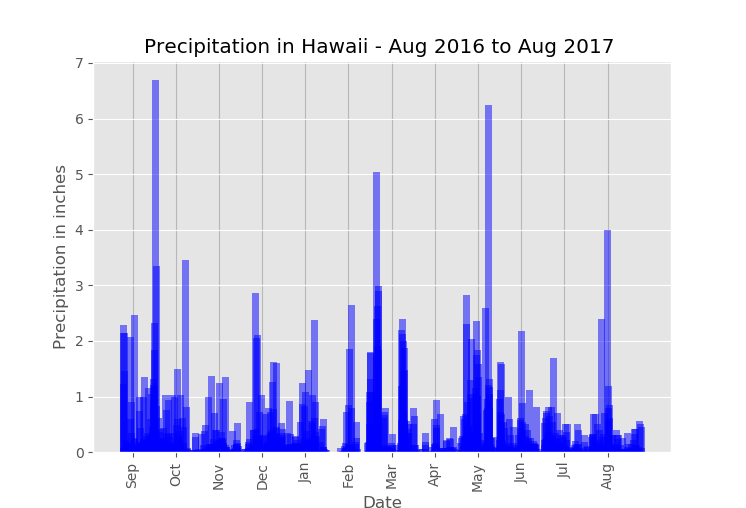

In [17]:
# Define X and Y values
x = np.arange(0, len(df_precipitation.index.tolist()), 1)
y = df_precipitation["Precipitation"].tolist()

# Define variables for x-ticks labels and locations
months = ["Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
month_step = int(len(y) / 12) 

# Plot bar chart
plt.bar(x, y, width=30, color="blue", alpha=0.5, align="edge")

# Incorporate other chart properties
plt.title("Precipitation in Hawaii - Aug 2016 to Aug 2017 ")
plt.xlabel("Date")
plt.ylabel("Precipitation in inches")
xtick_locations = range(56, len(y), month_step)
plt.xticks(xtick_locations, months, rotation=90)
plt.ylim = max(y) + 1
plt.grid(axis='x', alpha=0.20, color='black')

plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precipitation.describe()

,Precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


#### Climate Analysis - Stations

In [19]:
# Count of total number of stations
station_count = session.query(func.count(Station.station)).first()

# Print results 
print(f"Total number of Stations: {str(station_count[0])}")

Total number of Stations: 9


In [20]:
# Which are the most active stations?
busy_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Set above query results to dataframe
df_busy_stations = pd.DataFrame(busy_stations , columns=['Station', 'Count'])

df_busy_stations

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
# Which station has the highest number of observations?
# Set variables and Print results
st_busiest = df_busy_stations["Station"][0]
st_obs = df_busy_stations["Count"][0]

print(f"Station with the highest number of observations: {st_busiest} - {st_obs}")

Station with the highest number of observations: USC00519281 - 2772


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

st_busiest_obs = session.query(*sel).filter(Measurement.station == st_busiest).all()


print(f"The maximum temperature at the Station with the highest number of observations is: \
{st_busiest_obs[0][0]:.2f} degrees")

print(f"The minimum temperature at the Station with the highest number of observations is: \
{st_busiest_obs[0][1]:.2f} degrees")

print(f"The average temperature at the Station with the highest number of observations is: \
{st_busiest_obs[0][2]:.2f} degrees")

The maximum temperature at the Station with the highest number of observations is: 85.00 degrees
The minimum temperature at the Station with the highest number of observations is: 54.00 degrees
The average temperature at the Station with the highest number of observations is: 71.66 degrees


In [23]:
# Retrieve last 12 months of temperature observations
# Filter by the station with the highest number of observations.
st_busiest_12mth_obs = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-24').\
                       filter(Measurement.station == st_busiest).all()

# Convert result above to dataframe
df_st_busiest_12mth_obs = pd.DataFrame(st_busiest_12mth_obs, columns=['tobs'])

<IPython.core.display.Javascript object>


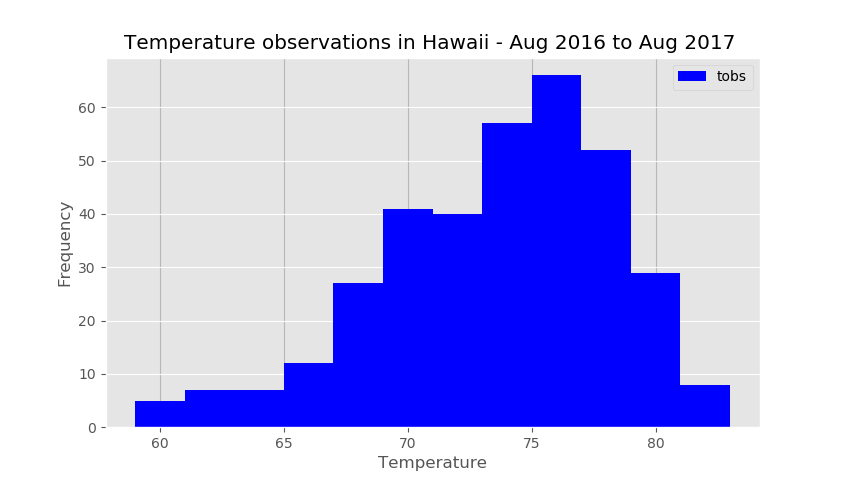

In [24]:
# Define plot parameters
data = pd.DataFrame(st_busiest_12mth_obs, columns=['tobs'])

# Plot histogram
data.plot.hist(grid=True, bins=12, rwidth=1,color='blue')

# Incorporate other plot properties
plt.title('Temperature observations in Hawaii - Aug 2016 to Aug 2017 ')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.grid(axis='x', alpha=0.20, color ='black')